# SOFC with Methane

This example shows a 1D isothermal SOFC (Solid oxide fuel cell) model.

The operating parameters chosen here are not necessarily realistic due to
constraints not included in this model. Under the example condition the
formation of solid carbon is for example very likely. A pre-reforming step
is typically applied when operating on methane.

In [1]:
import gaspype as gp
from gaspype.constants import R, F
import numpy as np
import matplotlib.pyplot as plt

Calculate equilibrium compositions for fuel and air sides
in counter flow along the fuel flow direction:

In [2]:
fuel_utilization = 0.90
air_utilization = 0.5
t = 800 + 273.15  # K
p = 1e5  # Pa

fs = gp.fluid_system('H2, H2O, O2, CH4, CO, CO2')
feed_fuel = gp.fluid({'CH4': 1, 'H2O': 0.1}, fs)

o2_full_conv = np.sum(gp.elements(feed_fuel).get_n(['H', 'C' ,'O']) * [1/4, 1, -1/2])

feed_air = gp.fluid({'O2': 1, 'N2': 4}) * o2_full_conv * fuel_utilization / air_utilization

conversion = np.linspace(0, fuel_utilization, 32)
perm_oxygen = o2_full_conv * conversion * gp.fluid({'O2': 1})

fuel_side = gp.equilibrium(feed_fuel + perm_oxygen, t, p)
air_side  = gp.equilibrium(feed_air  - perm_oxygen, t, p)

Plot compositions of the fuel and air side:

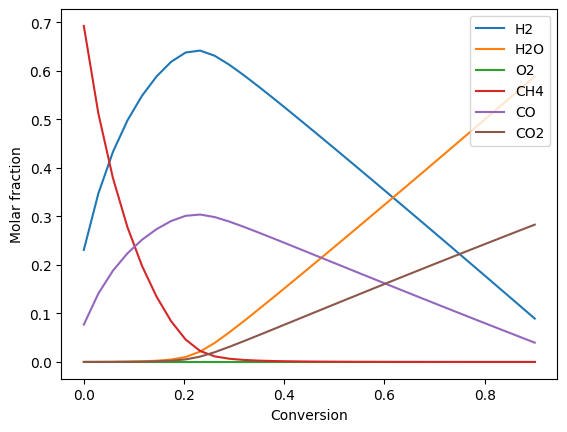

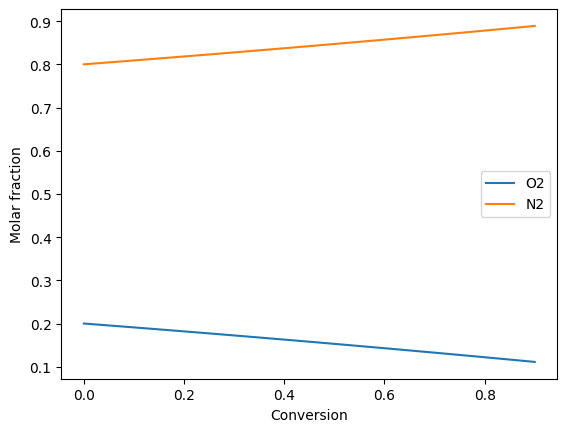

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Molar fraction")
ax.plot(conversion, fuel_side.get_x(), '-')
ax.legend(fuel_side.species)

fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Molar fraction")
ax.plot(conversion, air_side.get_x(), '-')
ax.legend(air_side.species)

Calculation of the oxygen partial pressures:

In [4]:
o2_fuel_side = gp.oxygen_partial_pressure(fuel_side, t, p)
o2_air_side = air_side.get_x('O2') * p

Plot oxygen partial pressures:

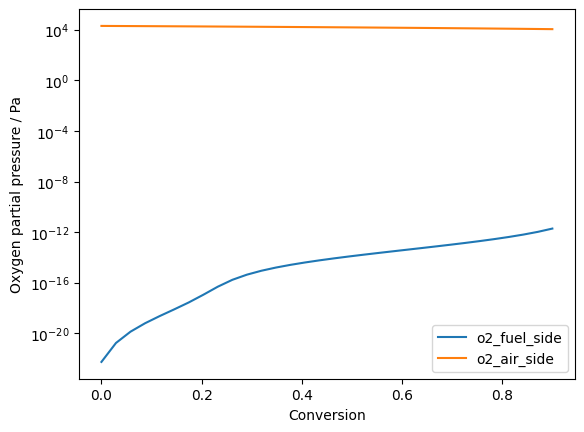

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Oxygen partial pressure / Pa")
ax.set_yscale('log')
ax.plot(conversion, np.stack([o2_fuel_side, o2_air_side], axis=1), '-')
ax.legend(['o2_fuel_side', 'o2_air_side'])

Calculation of the local nernst potential between fuel and air side:

In [6]:
z_O2 = 4  # Number of electrons transferred per O2 molecule
nernst_voltage = R*t / (z_O2*F) * np.log(o2_air_side/o2_fuel_side)

Plot nernst potential:

0.8389952262511841


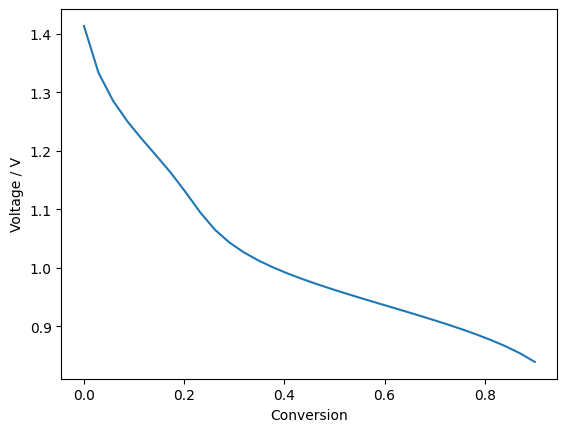

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Voltage / V")
ax.plot(conversion, nernst_voltage, '-')
print(np.min(nernst_voltage))

The model uses between each node a constant conversion. Because
current density depends strongly on the position along the cell
the constant conversion does not relate to a constant distance.

![Alt text](../../media/soc_inverted.svg)

To calculate the local current density (**node_current**) as well
as the total cell current (**terminal_current**) the (relative)
physical distance between the nodes (**dz**) must be calculated:

In [8]:
cell_voltage = 0.77  # V
ASR = 0.2  # Ohm*cm²

node_current = (nernst_voltage - cell_voltage) / ASR  # A/cm² (Current density at each node)

current = (node_current[1:] + node_current[:-1]) / 2  # A/cm² (Average current density between the nodes)

dz = 1/current / np.sum(1/current)  # Relative distance between each node

terminal_current = np.sum(current * dz) # A/cm² (Total cell current per cell area)

print(f'Terminal current: {terminal_current:.2f} A/cm²')

Terminal current: 0.94 A/cm²


Plot the local current density:

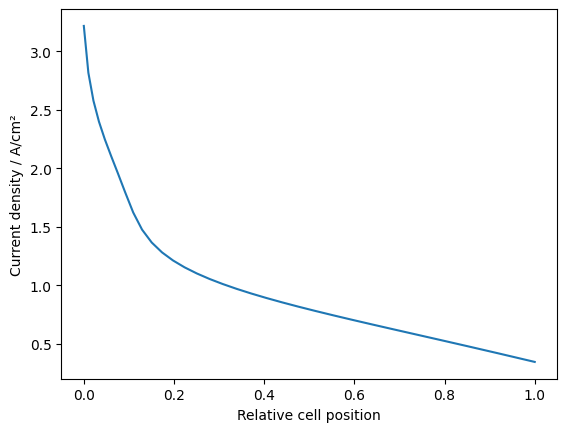

In [9]:
z_position = np.concatenate([[0], np.cumsum(dz)])  # Relative position of each node

fig, ax = plt.subplots()
ax.set_xlabel("Relative cell position")
ax.set_ylabel("Current density / A/cm²")
ax.plot(z_position, node_current, '-')

Based on the cell current and voltage the energy balance can be calculated.
In the following the electric cell output power (often referred to as "DC power")
and lower heating value (LHV) are calculated. The numbers here are per cell area for
being cell and stack size independent. The quotient of both is often referred to as
LHV based DC efficiency.

In [10]:
dc_power = cell_voltage * terminal_current  # W/cm²
print(f"DC power: {dc_power:.2f} W/cm²")

lhv = gp.fluid({'CH4': 1, 'H2O': -2, 'CO2': -1}).get_H(25 + 273.15)  # J/mol (LHV of methane)

# LHV based chemical input power:
lhv_power = lhv * terminal_current / (2 * z_O2 * F)  # W/cm² (two O2 per CH4 for full oxidation)
efficiency = dc_power / lhv_power
print(f"LHV based DC efficiency: {efficiency*100:.1f} %")

# Or by shortening the therms:
lhv_voltage = lhv / (2 * z_O2 * F)  # V
print(f"LHV voltage: {lhv_voltage:.2f} V")
efficiency = cell_voltage / lhv_voltage  # LHV based DC efficiency
print(f"LHV based DC efficiency: {efficiency*100:.1f} %")

DC power: 0.73 W/cm²
LHV based DC efficiency: 74.1 %
LHV voltage: 1.04 V
LHV based DC efficiency: 74.1 %
